# Estimating  Functional  Connectivity

In [1]:
from config import *
import sys
from src.data import subjects
import src.functional_connectivity.functional_connectivity as fc
import numpy as np

print('Denoising waiting list:\n',subjects.to_construct_correlation)
if subjects.to_construct_correlation == []:
    sys.exit("There is no subject to be denoised!")

Denoising waiting list:
 []


SystemExit: There is no subject to be denoised!

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Compute functional connectivity for all subjects

In [2]:
if 'pearson' in correlation_types:
    fc.all_pearsons(subjects.to_construct_correlation)
if 'partial' in correlation_types:
    fc.all_partial(subjects.to_construct_correlation)
if 'glasso' in correlation_types:
    alphaRange =np.arange(.01,.11,.01)
    ts = {}
    for sub in subjects.to_construct_correlation:
        ts[sub]={}
        for ds in denoising_strategies:
            ts[sub][ds] = np.load("%s/ds-%s/sub-%s_ds-%s.npy"
                                  %(subjects.time_seriesdir, ds, sub, ds))
    fc.all_glasso(timeseries=ts,alphaRange= alphaRange,tol=0.001,corr='separated',
                  sub_list=subjects.to_construct_correlation)

Computing Pearson correlation


### Import

In [3]:
%matplotlib inline
#%matplotlib notebook
import src.functional_connectivity.functional_connectivity as fc
import sys
from src.data import subjects
import os,sys
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import nibabel
from nibabel.gifti.gifti import GiftiImage,GiftiDataArray
from nilearn.connectome import ConnectivityMeasure
import nilearn.plotting
import sklearn.preprocessing
import sklearn.linear_model
import networkx as nx

### Read Data

In [32]:
correlation_types = ['glasso']

In [33]:
sub_list = ['006S4515']
ts = {}
for sub in sub_list:
    ts[sub]={}
    for ds in denoising_strategies:
        ts[sub][ds] = np.load("%s/ds-%s/sub-%s_ds-%s.npy"
                              %(subjects.time_seriesdir, ds, sub, ds))

In [34]:
correlations = {}

### Pearson correlation

Now let's compute the pearson correlation between all parcellations.

In [35]:
if 'pearson' in correlation_types:
    correlations['pearson']={}
    for ds in denoising_strategies:
        correlations['pearson'][ds] = np.corrcoef(ts[sub][ds][:,1:].T)  # drop the zero roi data
        # we end up with a few NAN values because of an empty ROI, for now just zero them out
        correlations['pearson'][ds][np.isnan(correlations['pearson'][ds])]=0

### Partial correlation

Correlation is sensitive both to direct connections between regions as well as indirect connections. Instead we might be interested in direct connections only, which can be estimated using partial correlation (also known as inverse covariance). Let's estimate that using the graphical lasso technique, which uses L1 regularization that imposes sparsity on the solution.  

In [36]:
if 'partial' in correlation_types:
    try:
        correlations['partial']={}
    except NameError:
        correlations = {'partial':{}}
    for ds in denoising_strategies:
        estimator=nilearn.connectome.ConnectivityMeasure(kind='partial correlation')
        t_s  = [ts[sub][ds][:,1:]]
        correlations['partial'][ds] = estimator.fit_transform(t_s)  # drop the zero roi data
        correlations['partial'][ds] = correlations['partial'][ds][0]
        correlations['partial'][ds][np.diag_indices_from(correlations['partial'][ds])]=0
        # we end up with a few NAN values because of an empty ROI, for now just zero them out
        correlations['partial'][ds][np.isnan(correlations['partial'][ds])]=0

### GLASSO

In [37]:
from sklearn import covariance, preprocessing

if 'glasso' in correlation_types:
    try:
        correlations['glasso']={}
    except NameError:
        correlations = {'glasso':{}}
    for ds in denoising_strategies:
        Scaler = preprocessing.StandardScaler()
        X = Scaler.fit_transform(ts[sub][ds][:,1:])
        emp_cov = covariance.empirical_covariance(X)
        shrunk_cov = covariance.shrunk_covariance(emp_cov, shrinkage=0.8) 
        #alphaRange1 = 10.0 ** (np.arange(-3,-2))
        #alphaRange = np.concatenate((alphaRange1,np.linspace(0.01, 0.15, num=6)))
        alphaRange = np.linspace(0.01, 0.1, num=19)
        correlations['glasso'][ds] = {}
        for alpha in alphaRange:
            try:
                correlations['glasso'][ds][alpha] = covariance.graphical_lasso(shrunk_cov, alpha,max_iter=500)
                print("Calculated graph-lasso covariance matrix for alpha=%s"%alpha)
                correlations['glasso'][ds][alpha][0][np.diag_indices_from(correlations['glasso'][ds][alpha][0])]=0
                correlations['glasso'][ds][alpha][1][np.diag_indices_from(correlations['glasso'][ds][alpha][1])]=0

            except FloatingPointError:
                print("Failed at alpha=%s"%alpha)

        #correlations['glasso'][ds] = correlations['glasso'][ds][0]
        #correlations['glasso'][ds][np.diag_indices_from(correlations['glasso'][ds])]=0
        # we end up with a few NAN values because of an empty ROI, for now just zero them out
        #correlations['glasso'][ds][np.isnan(correlations['glasso'][ds])]=0

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  check_random_state(None), False)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/sklearn/covariance/_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 500 iteration: dual gap: 1.762e-04
  % (max_iter, d_gap), ConvergenceWarning)


Calculated graph-lasso covariance matrix for alpha=0.01
Calculated graph-lasso covariance matrix for alpha=0.015000000000000001
Calculated graph-lasso covariance matrix for alpha=0.020000000000000004
Calculated graph-lasso covariance matrix for alpha=0.025
Calculated graph-lasso covariance matrix for alpha=0.030000000000000006
Calculated graph-lasso covariance matrix for alpha=0.035
Calculated graph-lasso covariance matrix for alpha=0.04000000000000001
Calculated graph-lasso covariance matrix for alpha=0.045000000000000005
Calculated graph-lasso covariance matrix for alpha=0.05000000000000001
Calculated graph-lasso covariance matrix for alpha=0.055000000000000014
Calculated graph-lasso covariance matrix for alpha=0.06000000000000001
Calculated graph-lasso covariance matrix for alpha=0.065
Calculated graph-lasso covariance matrix for alpha=0.07
Calculated graph-lasso covariance matrix for alpha=0.07500000000000001
Calculated graph-lasso covariance matrix for alpha=0.08
Calculated graph-

In [38]:
Pcorrelations = {}
Ncorrelations = {}
if 'glasso' in correlation_types:
    Pcorrelations['glasso']={}
    Ncorrelations['glasso']={}
    for ds in denoising_strategies:
        Pcorrelations['glasso'][ds]={}
        Ncorrelations['glasso'][ds]={}
        for alpha in alphaRange:
            Pcorrelations['glasso'][ds][alpha]=(correlations['glasso'][ds][alpha][0].clip(min=0),
                                                correlations['glasso'][ds][alpha][1].clip(min=0))
            Ncorrelations['glasso'][ds][alpha]=(correlations['glasso'][ds][alpha][0].clip(max=0),
                                                correlations['glasso'][ds][alpha][1].clip(max=0))

### Draw

In [39]:
if 'pearson' in correlation_types:
    ff = plt.figure(figsize=(10,10))
    ax=[]
    for i in range(len(denoising_strategies)):
        ax.append(ff.add_subplot((len(denoising_strategies)+1)//2,2,i+1))
    for i in range(len(denoising_strategies)):
        ax[i].imshow(correlations['pearson'][denoising_strategies[i]])
        ax[i].title.set_text(denoising_strategies[i])
    plt.tight_layout(pad=.5)
if 'partial' in correlation_types:
    ff = plt.figure(figsize=(10,10))
    ax=[]
    for i in range(len(denoising_strategies)):
        ax.append(ff.add_subplot((len(denoising_strategies)+1)//2,2,i+1))
    for i in range(len(denoising_strategies)):
        ax[i].imshow(correlations['partial'][denoising_strategies[i]])
        ax[i].title.set_text(denoising_strategies[i])
    plt.tight_layout(pad=.5)

It's clear from looking at the data that there is substantial structure in the correlations.  To see this more clearly, let's reorganize the data using the network assignments that were given to the regions on the basis of resting state correlation structurea by Yeo et al. (2011).

In [40]:
atlasdir=rootdir + '/references/HCP-MMP1'

In [41]:
# created previously using get_yeo_assignments.py
labelfile=os.path.join(atlasdir,'MMP_yeo2011_networks.csv')
labeldata=pd.read_csv(labelfile)

In [42]:
#labeldata

In [43]:
if 'pearson' in correlation_types:
    for i in range(len(denoising_strategies)):
        fc.plot_reordered_corrs(correlations['pearson'][denoising_strategies[i]],
                                labeldata,labels='YeoDesc7')
        plt.title(denoising_strategies[i])
        plt.show()
if 'partial' in correlation_types:

    for i in range(len(denoising_strategies)):
        fc.plot_reordered_corrs(correlations['partial'][denoising_strategies[i]],
                                labeldata,labels='YeoDesc7')
        plt.title(denoising_strategies[i])
        plt.show()

In [44]:
#for i in range(len(denoising_strategies)):
#    f.plot_reordered_corrs(correlations['pearson'][denoising_strategies[i]],labeldata,labels='YeoDesc17')
#    plt.title(denoising_strategies[i])
#    plt.show()

The (sparse) precision matrices


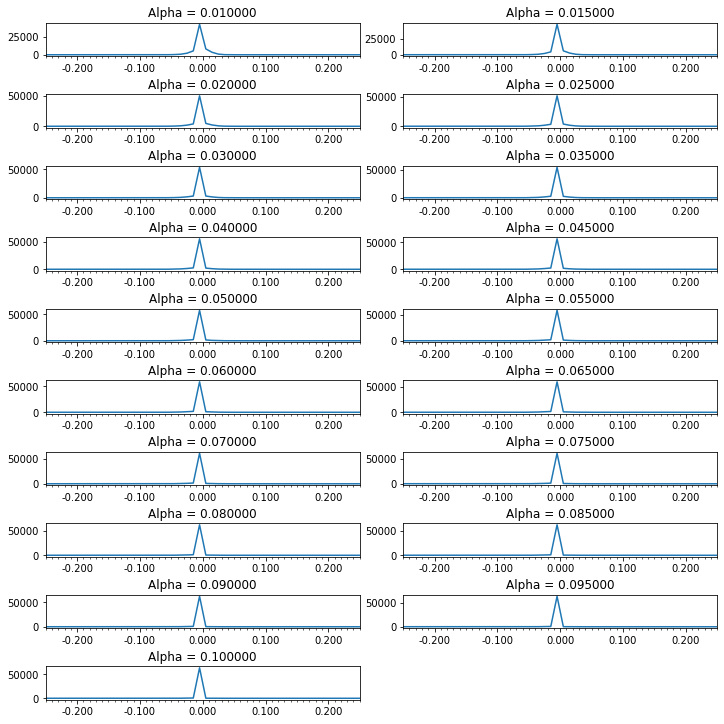

The covariance matrices


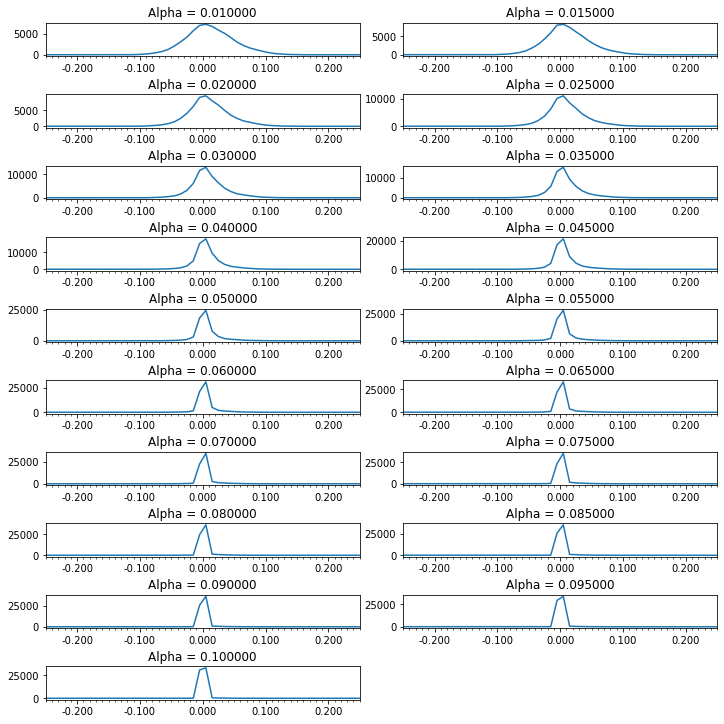

In [45]:
if 'pearson' in correlation_types:
    for ds in denoising_strategies:
        hist = np.histogram(correlations['pearson'][ds][np.triu_indices_from(correlations['pearson'][ds],1)],
                            np.arange(-1,1,0.01))
        plt.plot(np.arange(-0.995,0.995,0.01),hist[0])
        plt.xlabel('correlation value')
        plt.ylabel('count')
    plt.legend(denoising_strategies)
    plt.show()

if 'partial' in correlation_types:
    for ds in denoising_strategies:
        hist = np.histogram(correlations['partial'][ds][np.triu_indices_from(correlations['partial'][ds],1)],
                            np.arange(-1,1,0.01))
        plt.plot(np.arange(-0.995,0.995,0.01),hist[0])
        plt.xlabel('correlation value')
        plt.ylabel('count')
    plt.legend(denoising_strategies)
    plt.show()

if 'glasso' in correlation_types:
    ds = '36p'
    print('The (sparse) precision matrices')
    ff = plt.figure(figsize=(10,10))
    ax = [ff.add_subplot((len(alphaRange)+1)//2,2,i+1) for i in range(np.shape(alphaRange)[0])]
    for i in range(len(alphaRange)):
        corr = correlations['glasso'][ds][alphaRange[i]][1]
        hist = np.histogram(corr[np.triu_indices_from(corr,1)],
                            np.arange(-1,1,0.01))
        ax[i].set_xlim((-.25, .25))   # set the xlim to left, right
        ax[i].plot(np.arange(-0.995,0.995,0.01),hist[0])
        ax[i].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))
        ax[i].xaxis.set_major_locator(ticker.MultipleLocator(.1))
        ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(.01))
        ax[i].title.set_text("Alpha = %f"%alphaRange[i])
    plt.tight_layout(pad=.5)
    plt.show()
    print('The covariance matrices')
    ff = plt.figure(figsize=(10,10))
    ax = [ff.add_subplot((len(alphaRange)+1)//2,2,i+1) for i in range(np.shape(alphaRange)[0])]
    for i in range(len(alphaRange)):
        corr = correlations['glasso'][ds][alphaRange[i]][0]
        hist = np.histogram(corr[np.triu_indices_from(corr,1)],
                            np.arange(-1,1,0.01))
        ax[i].set_xlim((-.25, .25))   # set the xlim to left, right
        ax[i].plot(np.arange(-0.995,0.995,0.01),hist[0])
        ax[i].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))
        ax[i].xaxis.set_major_locator(ticker.MultipleLocator(.1))
        ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(.01))
        ax[i].title.set_text("Alpha = %8f"%alphaRange[i])
    plt.tight_layout(pad=.5)
    plt.show()

The (sparse) precision matrices


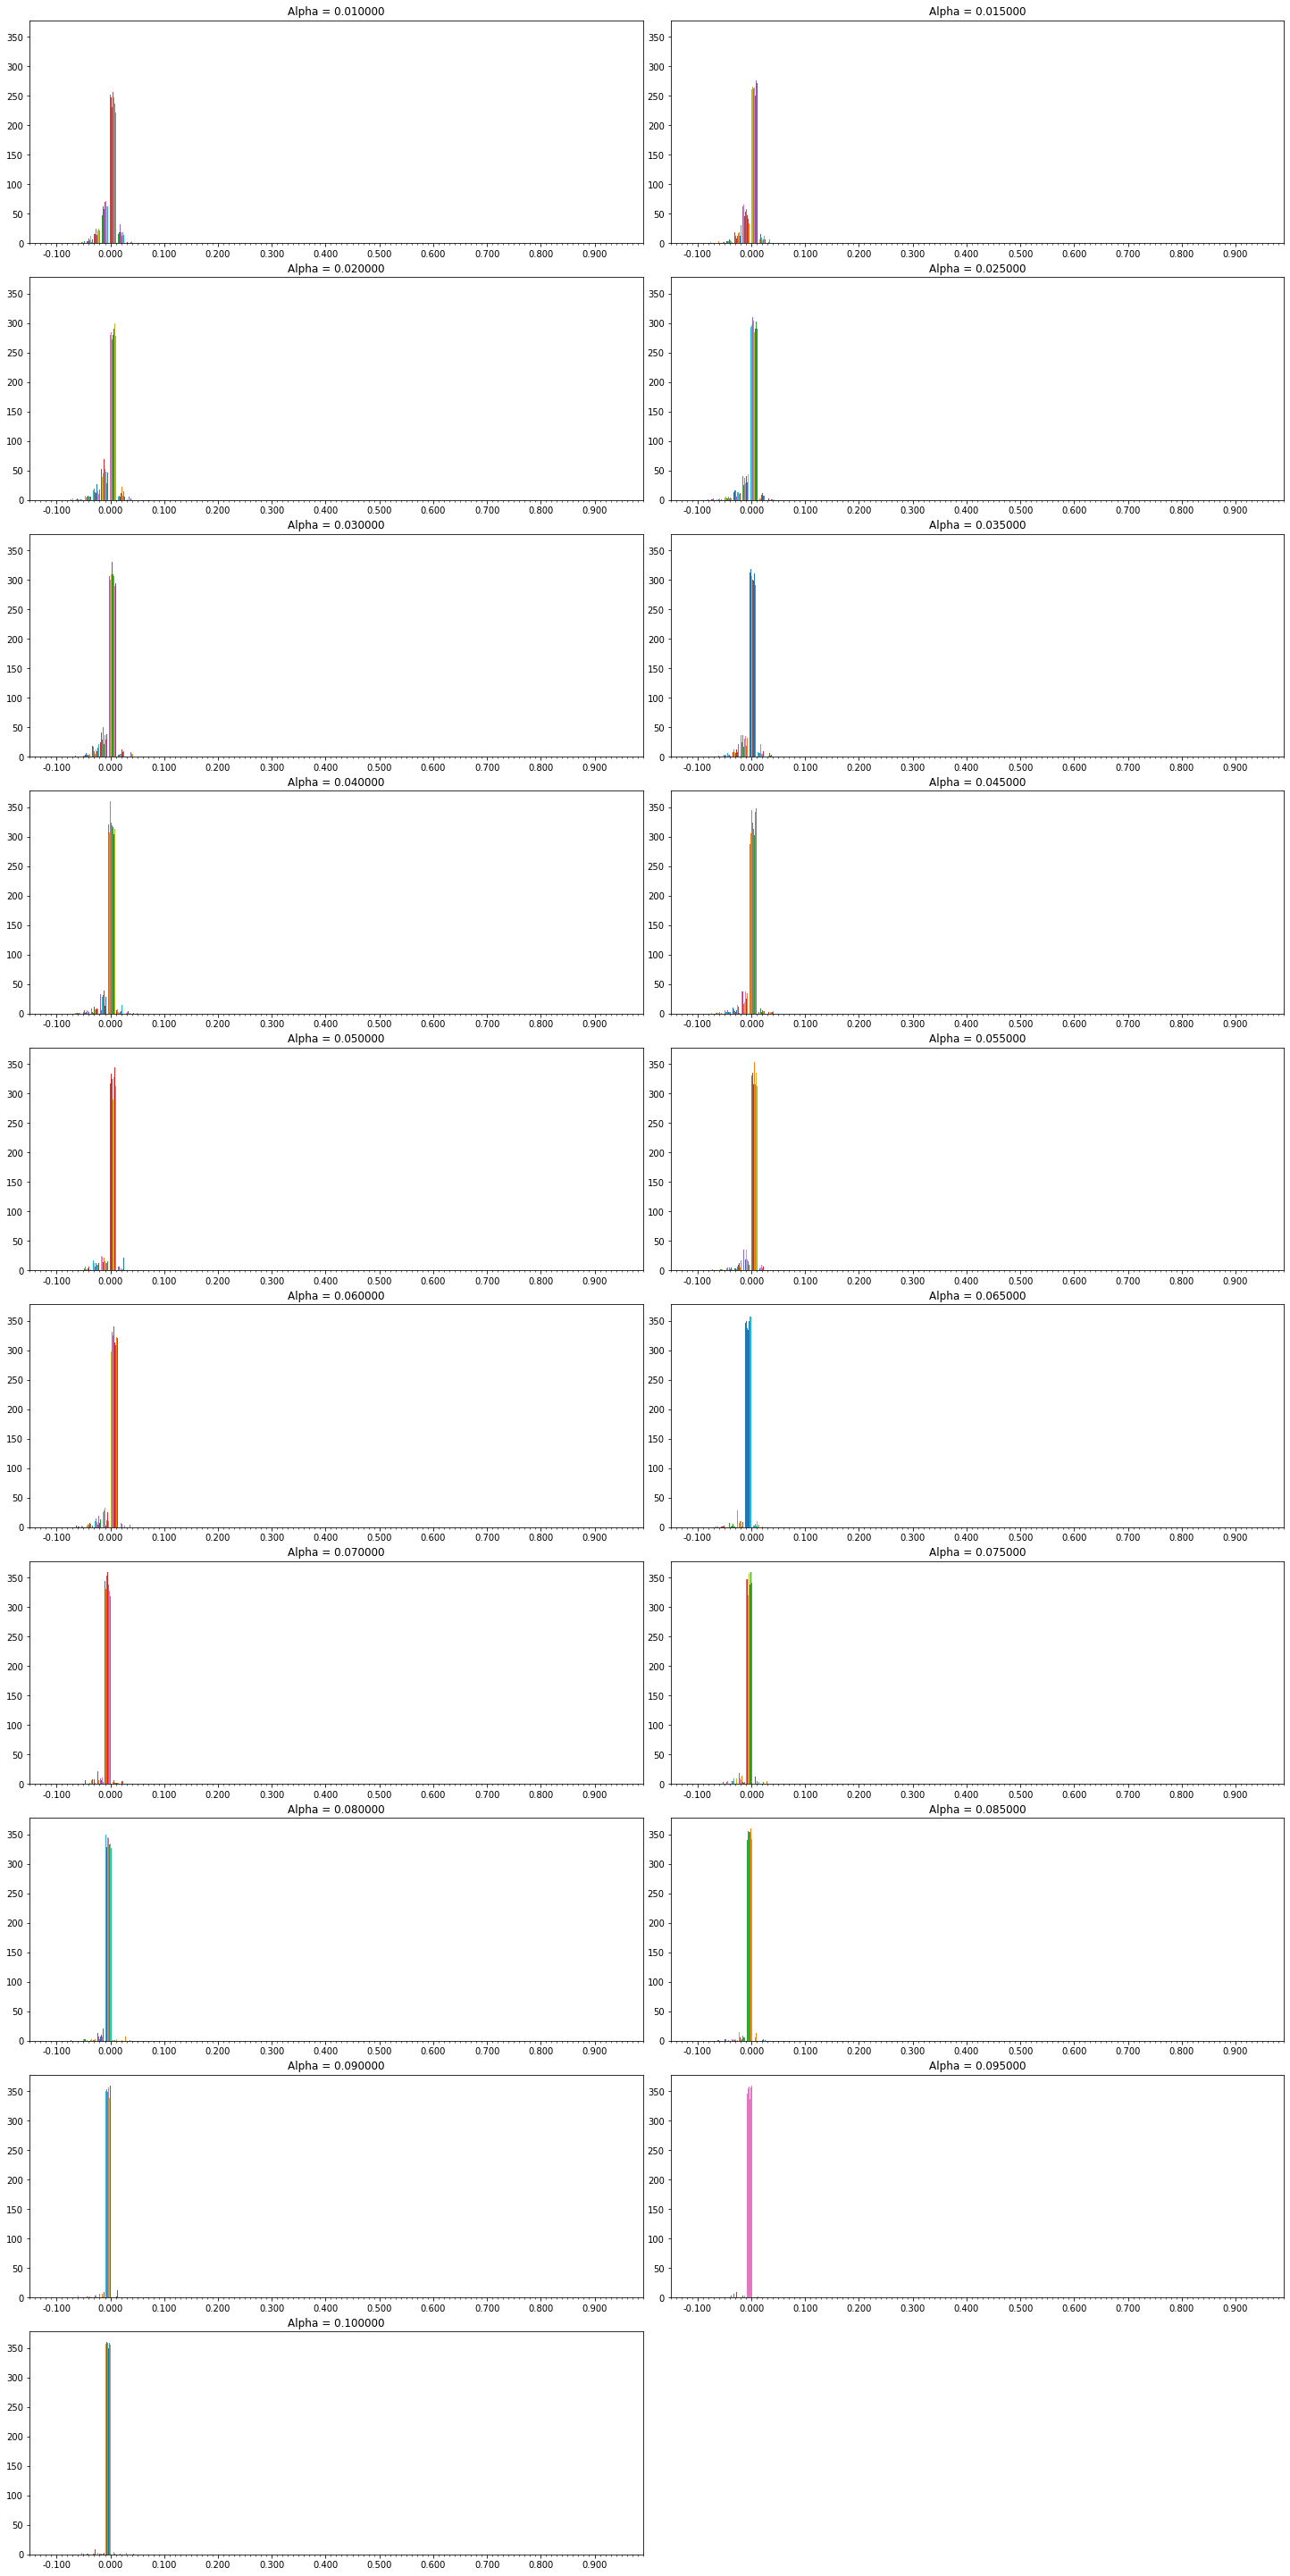

The covariance matrices


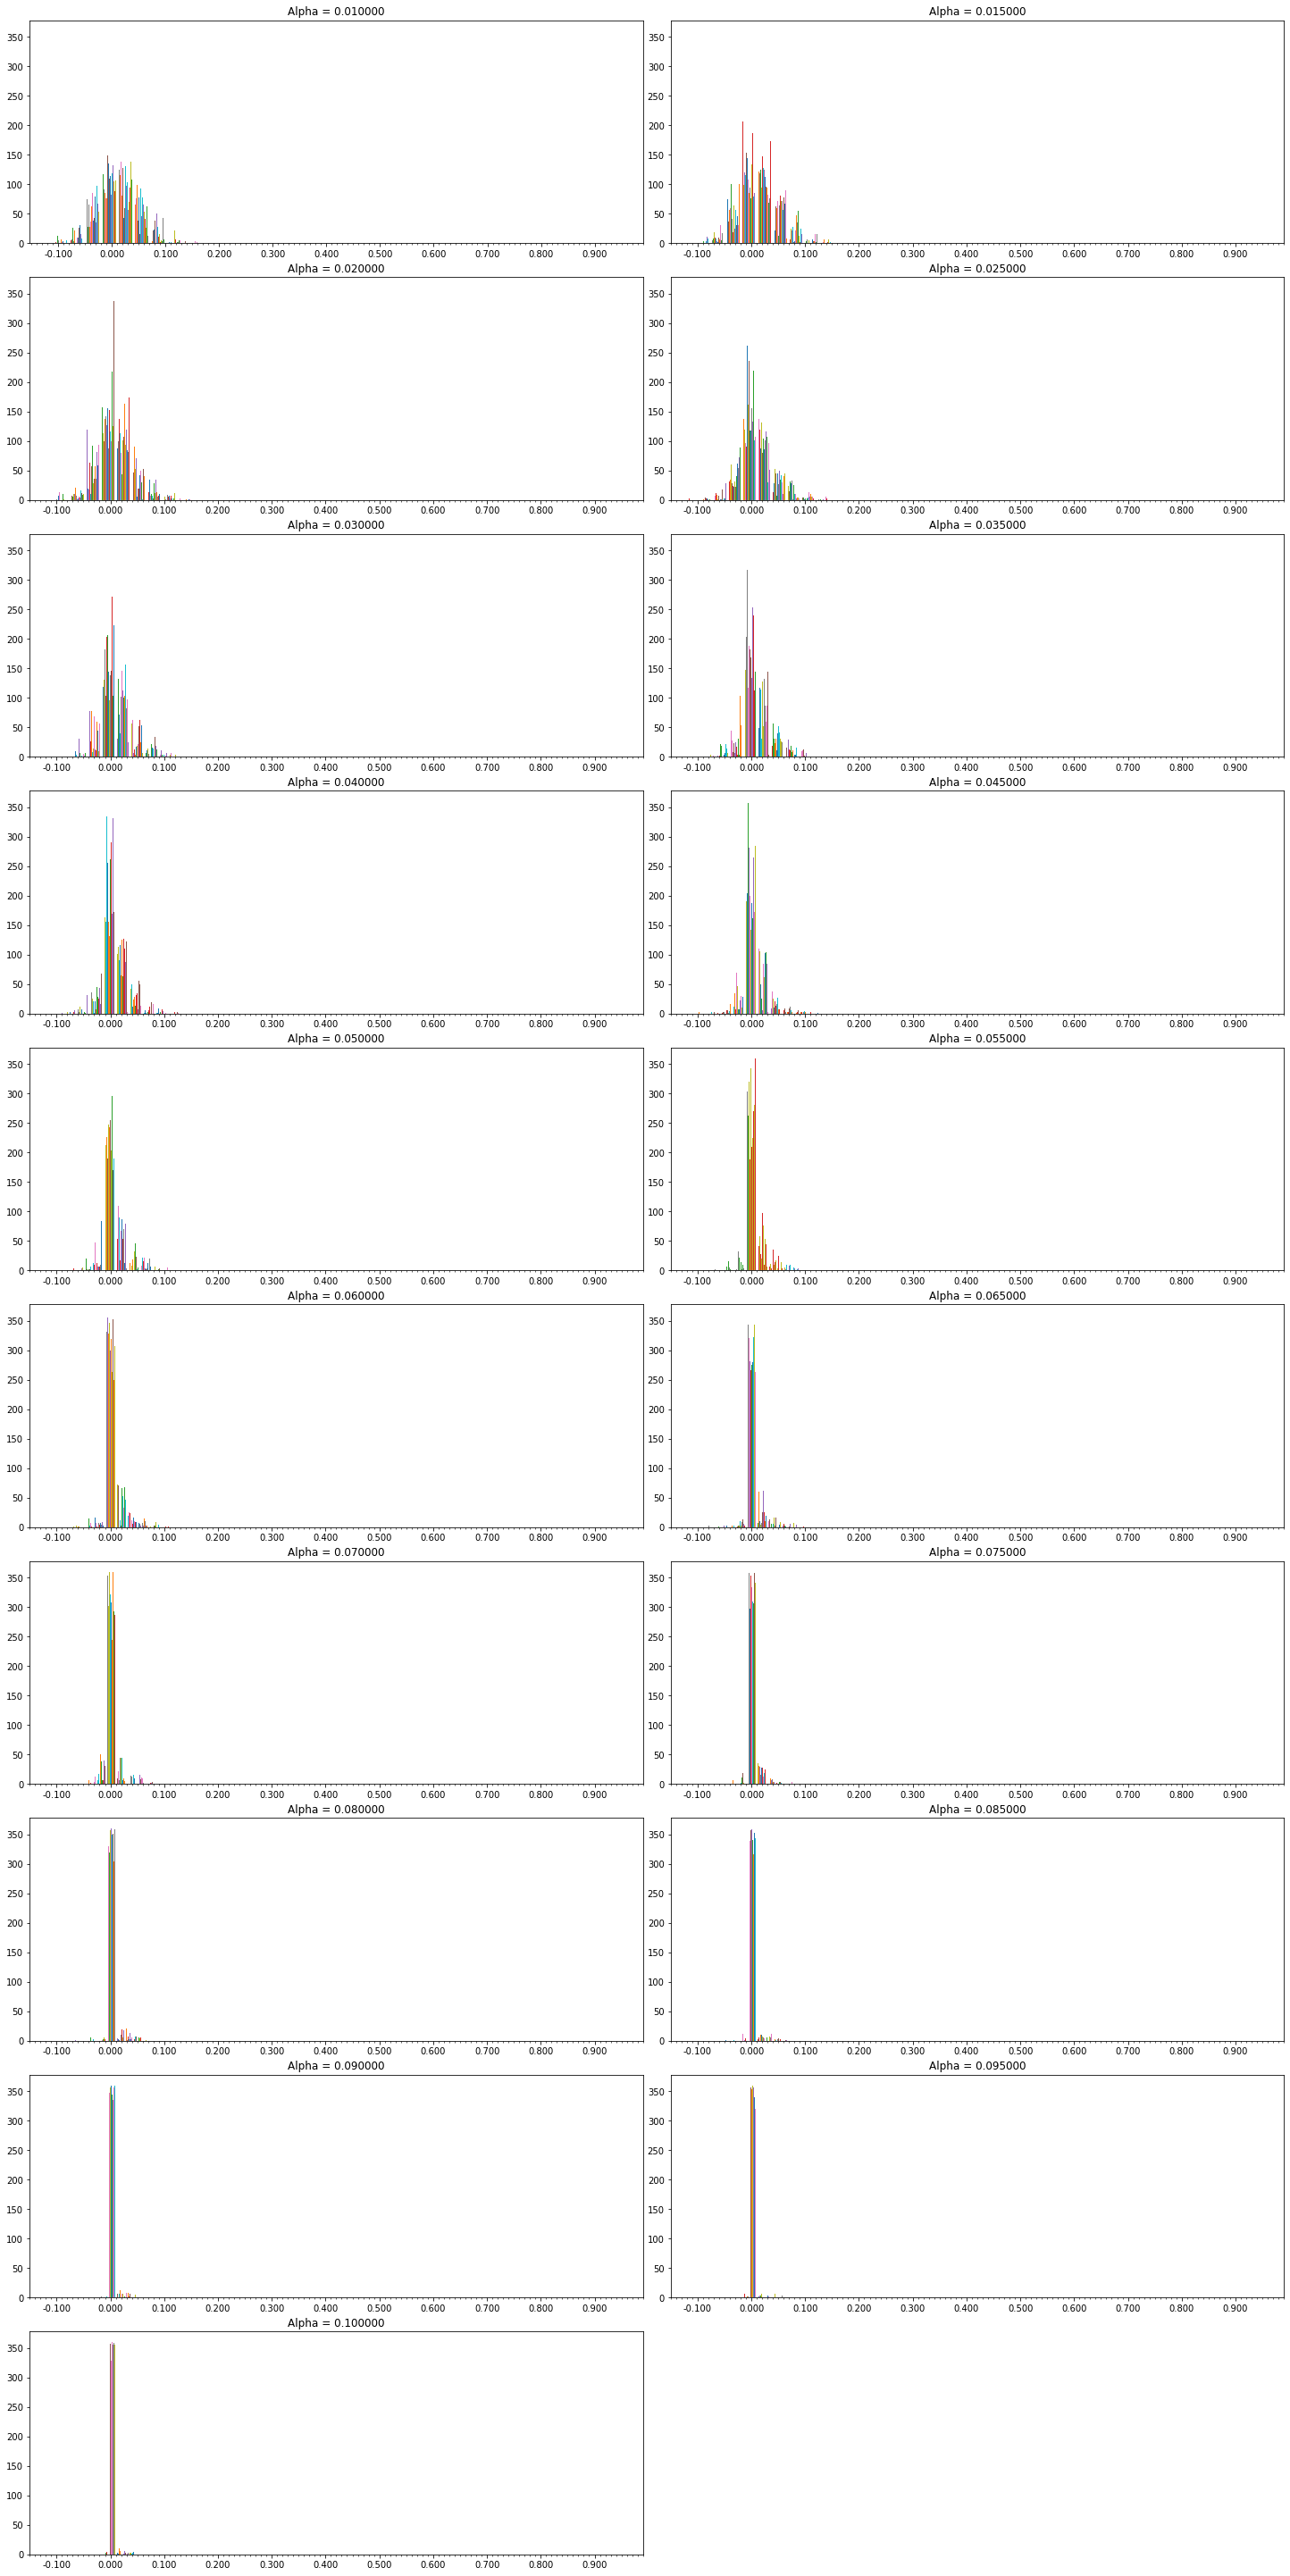

In [46]:
if 'partial' in correlation_types:
    for ds in denoising_strategies:
        _ = plt.hist(correlations['partail'][ds])
        plt.xticks(np.arange(-0.15,0.2,0.01))
        plt.xlabel('correlation value')
        plt.ylabel('count')
        plt.show()
if 'glasso' in correlation_types:
    ds = '36p'

    print('The (sparse) precision matrices')
    ff = plt.figure(figsize=(20,40))
    ax = [ff.add_subplot((len(alphaRange)+1)//2,2,i+1) for i in range(np.shape(alphaRange)[0])]
    for i in range(len(alphaRange)):
        corr = correlations['glasso'][ds][alphaRange[i]][1]
        ax[i].hist(corr)
        ax[i].set_xticks(np.arange(-0.15,1,0.01))
        ax[i].title.set_text("Alpha = %f"%alphaRange[i])
        ax[i].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))
        ax[i].xaxis.set_major_locator(ticker.MultipleLocator(.1))
        ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(.01))
    plt.tight_layout(pad=.5)
    plt.show()

    print('The covariance matrices')
    ff = plt.figure(figsize=(20,40))
    ax = [ff.add_subplot((len(alphaRange)+1)//2,2,i+1) for i in range(np.shape(alphaRange)[0])]
    for i in range(len(alphaRange)):
        corr = correlations['glasso'][ds][alphaRange[i]][0]
        ax[i].hist(corr)
        ax[i].set_xticks(np.arange(-0.15,1,0.01))
        ax[i].title.set_text("Alpha = %f"%alphaRange[i])
        ax[i].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))
        ax[i].xaxis.set_major_locator(ticker.MultipleLocator(.1))
        ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(.01))
    plt.tight_layout(pad=.5)
    plt.show()

In [47]:
if 'partial' in correlation_types:

    G = nx.from_numpy_array(correlations['partial'][ds])
    Gcc = sorted(nx.connected_components(G),key = len)
    print(sub, nx.density(G))
    G0 = G.subgraph(Gcc[-1])
    
if 'glasso' in correlation_types:
    print('Both positive and negative correlations:')
    print('The (sparse) precision matrices')
    for alpha in alphaRange:
        print('\talpha = %f'%alpha)
        G = nx.from_numpy_array(correlations['glasso'][ds][alpha][1])
        Gcc = sorted(nx.connected_components(G),key = len)
        G0 = G.subgraph(Gcc[-1])
        print('\t\tdensity: %.3f, number of nodes in its GC: %d'%(nx.density(G),len(G0.nodes())))
        
    print('The covariance matrices')
    for alpha in alphaRange:
        print('\talpha = %f'%alpha)
        G = nx.from_numpy_array(correlations['glasso'][ds][alpha][0])
        Gcc = sorted(nx.connected_components(G),key = len)
        G0 = G.subgraph(Gcc[-1])
        print('\t\tdensity: %.3f, number of nodes in its GC: %d'%(nx.density(G),len(G0.nodes())))

Both positive and negative correlations:
The (sparse) precision matrices
	alpha = 0.010000
		density: 0.495, number of nodes in its GC: 359
	alpha = 0.015000
		density: 0.396, number of nodes in its GC: 359
	alpha = 0.020000
		density: 0.332, number of nodes in its GC: 359
	alpha = 0.025000
		density: 0.286, number of nodes in its GC: 359
	alpha = 0.030000
		density: 0.250, number of nodes in its GC: 359
	alpha = 0.035000
		density: 0.222, number of nodes in its GC: 359
	alpha = 0.040000
		density: 0.198, number of nodes in its GC: 359
	alpha = 0.045000
		density: 0.178, number of nodes in its GC: 359
	alpha = 0.050000
		density: 0.160, number of nodes in its GC: 359
	alpha = 0.055000
		density: 0.143, number of nodes in its GC: 358
	alpha = 0.060000
		density: 0.126, number of nodes in its GC: 358
	alpha = 0.065000
		density: 0.112, number of nodes in its GC: 357
	alpha = 0.070000
		density: 0.098, number of nodes in its GC: 356
	alpha = 0.075000
		density: 0.085, number of nodes in i

In [48]:
if 'glasso' in correlation_types:
    print('positive correlation:')
    print('The (sparse) precision matrices')
    for alpha in alphaRange:
        print('\talpha = %f'%alpha)
        G = nx.from_numpy_array(Pcorrelations['glasso'][ds][alpha][1])
        Gcc = sorted(nx.connected_components(G),key = len)
        G0 = G.subgraph(Gcc[-1])
        print('\t\tdensity: %.3f, number of nodes in its GC: %d'%(nx.density(G),len(G0.nodes())))
        
    print('The covariance matrices')
    for alpha in alphaRange:
        print('\talpha = %f'%alpha)
        G = nx.from_numpy_array(Pcorrelations['glasso'][ds][alpha][0])
        Gcc = sorted(nx.connected_components(G),key = len)
        G0 = G.subgraph(Gcc[-1])
        print('\t\tdensity: %.3f, number of nodes in its GC: %d'%(nx.density(G),len(G0.nodes())))
        
    print('negative correlation:')
    print('The (sparse) precision matrices')
    for alpha in alphaRange:
        print('\talpha = %f'%alpha)
        G = nx.from_numpy_array(Ncorrelations['glasso'][ds][alpha][1])
        Gcc = sorted(nx.connected_components(G),key = len)
        G0 = G.subgraph(Gcc[-1])
        print('\t\tdensity: %.3f, number of nodes in its GC: %d'%(nx.density(G),len(G0.nodes())))        
        
    print('The covariance matrices')
    for alpha in alphaRange:
        print('\talpha = %f'%alpha)
        G = nx.from_numpy_array(Ncorrelations['glasso'][ds][alpha][0])
        Gcc = sorted(nx.connected_components(G),key = len)
        G0 = G.subgraph(Gcc[-1])
        print('\t\tdensity: %.3f, number of nodes in its GC: %d'%(nx.density(G),len(G0.nodes())))

positive correlation:
The (sparse) precision matrices
	alpha = 0.010000
		density: 0.198, number of nodes in its GC: 359
	alpha = 0.015000
		density: 0.151, number of nodes in its GC: 359
	alpha = 0.020000
		density: 0.119, number of nodes in its GC: 359
	alpha = 0.025000
		density: 0.097, number of nodes in its GC: 359
	alpha = 0.030000
		density: 0.081, number of nodes in its GC: 359
	alpha = 0.035000
		density: 0.068, number of nodes in its GC: 359
	alpha = 0.040000
		density: 0.058, number of nodes in its GC: 358
	alpha = 0.045000
		density: 0.049, number of nodes in its GC: 355
	alpha = 0.050000
		density: 0.041, number of nodes in its GC: 350
	alpha = 0.055000
		density: 0.035, number of nodes in its GC: 344
	alpha = 0.060000
		density: 0.029, number of nodes in its GC: 334
	alpha = 0.065000
		density: 0.023, number of nodes in its GC: 321
	alpha = 0.070000
		density: 0.019, number of nodes in its GC: 305
	alpha = 0.075000
		density: 0.015, number of nodes in its GC: 276
	alpha =

In [49]:
ds_couples = [(a,b) for a in denoising_strategies for b in set(denoising_strategies)-{a}]
l = len(denoising_strategies)
ds_couples = ds_couples[0:int(l*(l-1)/2)]
ds_couples

[]

In [50]:
if 'pearson' in correlation_types:
    ff = plt.figure(figsize=(10,10))
    ax=[]
    for i in range(len(ds_couples)):
        ax.append(ff.add_subplot((len(denoising_strategies)+1)//2,2,i+1))
    for i in range(len(ds_couples)):
        ax[i].scatter(correlations['pearson'][ds_couples[i][0]][np.triu_indices_from(correlations['pearson'][ds_couples[i][0]],1)],
                      correlations['pearson'][ds_couples[i][1]][np.triu_indices_from(correlations['pearson'][ds_couples[i][1]],1)])
        ax[i].plot([-1,1],[-1,1],'k-')
        ax[i].axis([-1,1,-1,1])
        ax[i].set_xlabel(ds_couples[i][0])
        ax[i].set_ylabel(ds_couples[i][1])
        #ax[i].title.set_text(denoising_strategies[i])
    plt.tight_layout(pad=.5)
    plt.show()
if 'glasso' in correlation_types:
    ff = plt.figure(figsize=(10,10))
    ax=[]
    for i in range(len(ds_couples)):
        ax.append(ff.add_subplot((len(denoising_strategies)+1)//2,2,i+1))
    for i in range(len(ds_couples)):
        ax[i].scatter(correlations['partial'][ds_couples[i][0]][np.triu_indices_from(correlations['partial'][ds_couples[i][0]],1)],
                      correlations['partial'][ds_couples[i][1]][np.triu_indices_from(correlations['partial'][ds_couples[i][1]],1)])
        ax[i].plot([-1,1],[-1,1],'k-')
        ax[i].axis([-1,1,-1,1])
        ax[i].set_xlabel(ds_couples[i][0])
        ax[i].set_ylabel(ds_couples[i][1])
        #ax[i].title.set_text(denoising_strategies[i])
    plt.tight_layout(pad=.5)
    plt.show()

<Figure size 720x720 with 0 Axes>

### Export

In [51]:
%%javascript
Jupyter.notebook.save_checkpoint()

<IPython.core.display.Javascript object>

In [52]:
%%javascript
Jupyter.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [53]:
#os.system("cp %sconnectivity_derivs/codes/Pipeline/04_estimating_functional_connectivity.ipynb /home/alireza/Thesis/Databases/ADNI/connectivity_derivs/codes/Denoising/sub-%s_functional_connectivity.ipynb"%(workdir,sub))